In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

%matplotlib inline


In [254]:
selected_columns = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                    'population', 'households', 'median_income', 'median_house_value','ocean_proximity']

df = pd.read_csv('../../data/housing.csv', usecols=selected_columns)
df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [255]:
# Fill missing values
total_bedrooms_median = df.total_bedrooms.median()
df.total_bedrooms.fillna(total_bedrooms_median, inplace=True)

df.total_bedrooms.isna().mean()


0.0

In [256]:
df.total_bedrooms.isna().mean()
# Create new columns
df['rooms_per_household'] = df.total_rooms / df.households
df['bedrooms_per_room'] = df.total_bedrooms / df.total_rooms
df['population_per_household'] = df.population / df.households

mhv_mean = df.median_house_value.mean()
df['above_average'] = (df.median_house_value > mhv_mean).astype('int')
df.above_average.value_counts()

0    12255
1     8385
Name: above_average, dtype: int64

In [257]:
seed = 42
df_full_train, df_test =train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']


In [258]:
numerical = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "rooms_per_household",
       "bedrooms_per_room", "population_per_household"]
categorical = ["ocean_proximity"]
features = categorical + numerical


In [259]:
scores = []
for n in numerical:
    score = roc_auc_score(y_train, df_train[n])
    scores.append((n, score))

scores


[('longitude', 0.4320229720528077),
 ('latitude', 0.44779099650984144),
 ('housing_median_age', 0.5447604712318991),
 ('total_rooms', 0.6017295171371194),
 ('total_bedrooms', 0.5371505385809857),
 ('population', 0.4863266296768039),
 ('households', 0.54868039179385),
 ('median_income', 0.8276414604097286),
 ('rooms_per_household', 0.6493014120063529),
 ('bedrooms_per_room', 0.32458144182262494),
 ('population_per_household', 0.35046568212337137)]

In [260]:

def train(df, y, c=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver="liblinear", C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y)

    return dv, model

In [261]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred


In [262]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

In [263]:
round(roc_auc_score(y_val, y_pred),3)


0.913

In [264]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)


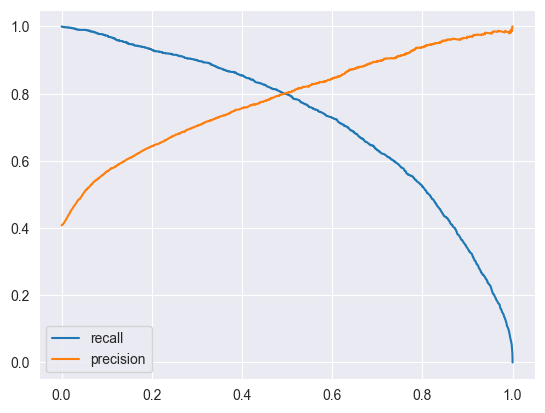

In [265]:
plt.plot(thresholds, recall[1:], label='recall')
plt.plot(thresholds, precision[1:], label='precision')
plt.legend()
plt.show()


In [266]:
f1_scores = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))


Best threshold:  0.38759912692537185
Best F1-Score:  0.8036504424778762


In [267]:
def kfold_scores(kfold, df_full_train, c):
    scores = []
    for train_idxs, val_idxs in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idxs]
        df_val = df_full_train.iloc[val_idxs]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        scores.append(roc_auc_score(y_val, y_pred))
    return scores

n_split = 5
kfold = KFold(n_splits=n_split, shuffle=True, random_state=1)
for c in tqdm([0.01, 0.1, 0.5, 1, 10]):
    scores = kfold_scores(kfold, df_full_train, c)
    print('%s -> %.3f +/- %.3f' % (c, np.mean(scores), np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

0.01 -> 0.907 +/- 0.005
0.1 -> 0.908 +/- 0.005
0.5 -> 0.907 +/- 0.005
1 -> 0.908 +/- 0.005
10 -> 0.908 +/- 0.005


In [268]:
dv, model = train(df_train, y_train, 0.1)
y_pred = predict(df_val, dv, model)

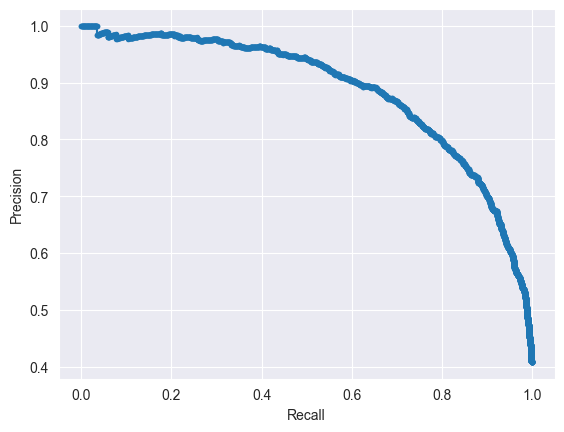

In [269]:
lr_precision, lr_recall, _ = precision_recall_curve(y_val, y_pred)
lr_auc = auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()